In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
from tqdm import tqdm

%matplotlib inline

In [2]:
ref = pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\ngdbrock-fUS56\tblRockGeoData.csv', index_col = [0])

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (12,14,26,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})

In [4]:

from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(ref.longitude, ref.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = GeoDataFrame(ref, crs={'init': 'epsg:4326'}, geometry=geometry)
#geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)
val_huc = gpd.sjoin(huc12, projGeoDF)

In [5]:
val_huc = gpd.sjoin(huc12, projGeoDF)

In [6]:
val_huc = val_huc.merge(data, on='lab_id') #this is the chemical data joined with the HUC dataset

NameError: name 'data' is not defined

In [ ]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)
frame['HUC_12']=frame.HUC_12.astype(str)
CaptainHucstable = huc12.merge(frame, on='HUC_12' )

In [78]:
true_vals = []
for samples in tqdm(range(len(val_huc))):
    true_vals.append(val_huc.loc[samples].HUC_12)

bflat = []  
for samples in tqdm(range(4)):#len(val_huc))):
    formation = val_huc.loc[samples].stratgrphy[0:10]
    b = []
    for element in range(58,113):
        ppm = val_huc.columns[element] #select each element in the list
        valued = val_huc.loc[samples][element] #select each elements values 
        #from the big list, select element, formation, and concentration greater than the sample has, and create a list of the
        #basins that we should explore
        b0 = CaptainHucstable[(CaptainHucstable['element']== ppm) & (CaptainHucstable['formation'].str.contains(formation)) &(
            CaptainHucstable['bins_ppm']>= valued) & (CaptainHucstable['prob']>0.1)].HUC_12.values
        b.append(b0)
    bflat.append(np.unique(np.asarray([item for sublist in b for item in sublist])))
preds = np.unique(np.asarray([item for sublist in bflat for item in sublist]))
TP = len(set(true_vals).intersection(preds))
FP = len(preds)-len(set(true_vals).intersection(preds))
TN = len(huc12.HUC_12.unique())-len(preds)
FN = len(set(true_vals).intersection(set(huc12.HUC_12.unique()) ^ set(preds)))

#precision = TP/(TP+FP)
#recall = TP/(TP+FN)
#acc = (TP+TN)/(TP+TN+FP+FN)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:25<00:00, 96.37s/it]


In [79]:
print([TP, FP, TN, FN])

[0, 0, 2382, 106]


Let's try something other than predicting locations

In [79]:
path = r'J:\\Geology\\WSGS\\GIS\\Predicted locations\\'
allFiles=glob.glob(path+"*.shp")
points = gpd.read_file(r'J:\Geology\WSGS\GIS\usgs_locations.shp')
points= points.to_crs({'init': 'epsg:3732'})

validations = []
for shapefile in allFiles:
    shape = gpd.read_file(shapefile)
    shape = shape.to_crs({'init': 'epsg:3732'})
    chosen = gpd.sjoin(points, shape)
    chosen['element'] = shapefile[-10:-4]
    validations.append(chosen)

In [95]:
selectedSamples = pd.concat(validations)

In [85]:
selectedSamples.to_file(driver='ESRI Shapefile', filename='usgs_samples_clipped.shp')

AttributeError: 'DataFrame' object has no attribute 'to_file'

In [138]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\ngdbrock-fUS56\\ngdbrock-fUS56\\'
allFiles=glob.glob(path+"*.csv")

es = pd.read_csv(allFiles[0], index_col = [0])
paes = pd.read_csv(allFiles[1], index_col = [0])
pms = pd.read_csv(allFiles[2], index_col = [0])
naa = pd.read_csv(allFiles[3], index_col = [0])
other = pd.read_csv(allFiles[4], index_col = [0])
unk = pd.read_csv(allFiles[5], index_col = [0])
xrf = pd.read_csv(allFiles[6], index_col = [0])

In [139]:
es2 = ref.join(naa, how='right')

In [140]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(es2.longitude, es2.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = gpd.GeoDataFrame(es2, crs={'init': 'epsg:4326'}, geometry=geometry)
points=geo_df.to_crs(crs)

In [141]:
path = r'J:\\Geology\\WSGS\\GIS\\Predicted locations\\'
allFiles=glob.glob(path+"*.shp")

validations = []
for shapefile in allFiles:
    shape = gpd.read_file(shapefile)
    shape = shape.to_crs({'init': 'epsg:3732'})
    chosen = gpd.sjoin(points, shape)
    chosen['element'] = shapefile[-10:-4]
    validations.append(chosen)

In [142]:
selectedSamples = pd.concat(validations)
selectedSamples.to_file(driver='ESRI Shapefile', filename='naa_samples_clipped.shp')

bring in the clipped sample points

In [143]:
t = gpd.read_file(r'D:\jupyter\naa_samples_clipped.shp')
t.columns

Index(['ACRES', 'AREA', 'FID_BLM__S', 'FID_lessth', 'HOLDAGENCY', 'Id',
       'NCONTRB_A', 'Name', 'OBJECTID', 'PERIMETER',
       ...
       'u_ppm', 'u_ppm.1', 'v_ppm', 'w_ppm', 'xndryclass', 'y_ppm', 'yb_ppm',
       'zn_ppm', 'zr_ppm', 'geometry'],
      dtype='object', length=103)

In [144]:
crustal_abundance=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\crustal_abundance1.csv',encoding = "ISO-8859-1")
ca = crustal_abundance.set_index('source').T

In [145]:
predicted = []
actuals = []
for i in range(len(t)):
    try:
        predicted.append(5*ca[ca.index== t.iloc[i].element].mean_ppm.values[0])
    except:
        print(str(t.iloc[i].element)+' is broken')
    try:
        actuals.append(t.iloc[i][t.iloc[i].element])
    except:
        actuals.append(0)

In [146]:
flat_preds = np.asarray(predicted)

In [147]:
flat_actual = np.asarray(actuals)

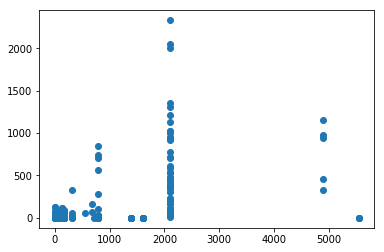

In [148]:
plt.scatter(flat_preds, flat_actual)

In [149]:
t['predicted'] = flat_preds
t['actual'] = flat_actual

In [150]:
t[t['element'] == t.element.unique()[6]]

,ACRES,AREA,FID_BLM__S,FID_lessth,HOLDAGENCY,Id,NCONTRB_A,Name,OBJECTID,PERIMETER,...,v_ppm,w_ppm,xndryclass,y_ppm,yb_ppm,zn_ppm,zr_ppm,geometry,predicted,actual
355,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,0.780,metamorphic,None,0.6300,174.00,25.0,POINT (3061897.246375395 693985.600143757),1614.5,0
356,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,3.850,metamorphic,None,0.6070,8.89,59.0,POINT (3063829.296462075 692861.1269228761),1614.5,0
357,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,1.200,metamorphic,None,0.5470,239.00,8.4,POINT (3063905.024466082 692864.7382313806),1614.5,0
358,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,139.000,metamorphic,None,1.5000,539.00,26.0,POINT (3063905.024466082 692864.7382313806),1614.5,0
359,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,4.300,metamorphic,None,0.0745,5.60,5.5,POINT (3060057.474824927 691461.4077940361),1614.5,0
360,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,0.913,metamorphic,None,0.0560,6.43,8.7,POINT (3060057.474824927 691461.4077940361),1614.5,0
361,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,4.010,metamorphic,None,0.8090,40.80,26.0,POINT (3064151.507079037 692470.9822813432),1614.5,0
362,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,4.300,metamorphic,None,0.8310,22.30,22.0,POINT (3064151.507079037 692470.9822813432),1614.5,0
363,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,4.390,metamorphic,None,0.8380,532.00,23.0,POINT (3066511.039317416 696642.4714196009),1614.5,0
364,1.401613e+06,0.622481,NaN,NaN,None,NaN,0.0,None,NaN,40.168844,...,None,NaN,metamorphic,None,1.7800,NaN,87.0,POINT (2955782.885990962 521827.6969322335),1614.5,0


In [151]:
from sklearn.metrics import mean_squared_error

rmse = []
for i in range(len(t.element.unique())):
    try:
        rmse.append(np.sqrt(mean_squared_error(t[t['element'] == t.element.unique()[i]].actual, t[t['element'] == 
                                                                                  t.element.unique()[i]].predicted)))
    except:
        rmse.append(np.nan)

In [152]:
rmse

[0.375,
 40.83,
 nan,
 nan,
 12.166666665000001,
 0.135833335,
 1614.5,
 nan,
 nan,
 nan,
 1395.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 10.86,
 nan,
 95.0,
 11.7,
 nan,
 nan,
 nan,
 95.0,
 nan,
 63.33333335,
 5550.0,
 560.7435287187897,
 65.9134196252343,
 712.5,
 153.33333335]

In [153]:
t.element.unique()

array(['ag_ppm', 'al_pct', 'as_ppm', 'ba_ppm', 'be_ppm', 'bi_ppm',
       '\\b_ppm', 'ca_pct', 'cd_ppm', 'ce_ppm', 'cl_ppm', 'co_ppm',
       'cr_ppm', 'cs_ppm', 'cu_ppm', 'dy_ppm', 'eu_ppm', 'fe_pct',
       'hf_ppm', '\\k_pct', 'la_ppm', 'li_ppm', 'mg_pct', 'mn_ppm',
       'mo_ppm', 'na_pct', 'nb_ppm', 'ni_ppm', 'pb_ppm', '\\p_ppm',
       'rb_ppm', 'sc_ppm', '\\v_ppm', '\\y_ppm'], dtype=object)

In [154]:
deets = pd.DataFrame([rmse], columns =t.element.unique() )


In [155]:
deets.to_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\ngdbrock-fUS56\accuracy\naa.csv')